In [435]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

In [2]:
data = pd.read_csv('data/fires.csv')
data

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


Let's investigate the data at first. 

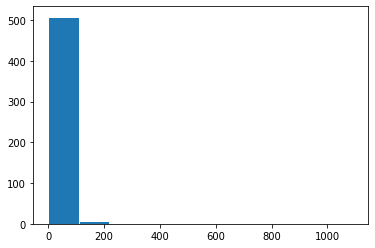

In [3]:
plt.hist(data['area'], bins=10, edgecolor='white', linewidth=1)
plt.show()

We can see, that 'area' is distributed very non-uniformly, therefore, we perform scaling. 

In [4]:
data.loc[:, 'area'] = data.loc[:, 'area'].apply(lambda x: np.log(1+x))

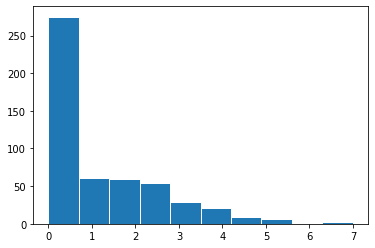

In [5]:
plt.hist(data['area'], bins=10, edgecolor='white', linewidth=1)
plt.show()

Let's take a look at the 'rain' column. 

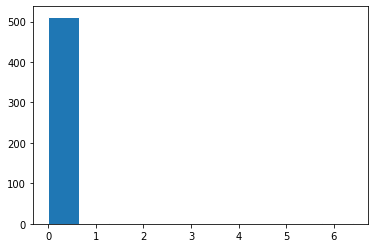

In [6]:
plt.hist(data['rain'], bins=10, edgecolor='white', linewidth=1)
plt.show()

In [671]:
data[data['rain'] != 0].shape

(8, 30)

Most of the 'rain' values are zero. Let's substitute it with 1 when there was rain and 0 when there wasn't. 

In [8]:
data['rain'] = (data['rain'] > 0).astype(int)

We have the following categorical values: 
- month
- day

Let's transform them so we can work with it.

In [9]:
data = pd.get_dummies(data)

Now let's normilize the data with MinMax normalization, since our data is quite on a different scale, which may lead to the lower model performance. 

In [10]:
data = (data - data.min()) / (data.max() - data.min())
data

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_nov,month_oct,month_sep,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,0.750,0.428571,0.870968,0.086492,0.101325,0.090909,0.192926,0.423529,0.700000,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.750,0.285714,0.927742,0.118194,0.775419,0.119430,0.508039,0.211765,0.055556,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.750,0.285714,0.927742,0.146795,0.796294,0.119430,0.398714,0.211765,0.100000,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.875,0.571429,0.941935,0.110958,0.081623,0.160428,0.196141,0.964706,0.400000,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.875,0.571429,0.910968,0.172984,0.110590,0.171123,0.295820,0.988235,0.155556,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,0.375,0.142857,0.811613,0.191592,0.771315,0.033868,0.823151,0.200000,0.255556,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
513,0.125,0.285714,0.811613,0.191592,0.771315,0.033868,0.633441,0.658824,0.600000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
514,0.750,0.285714,0.811613,0.191592,0.771315,0.033868,0.610932,0.647059,0.700000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
515,0.000,0.285714,0.976774,0.499311,0.711622,0.201426,0.752412,0.317647,0.400000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now let's check whether there are any correlation in our data. 

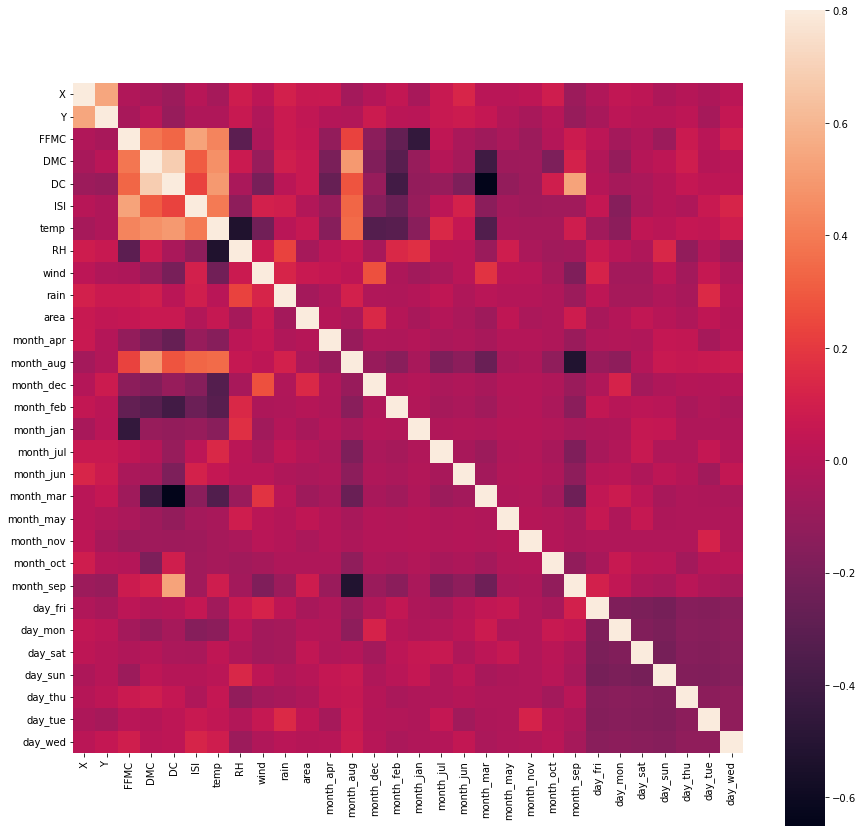

In [11]:
fig = plt.figure(figsize = (15,15))

sns.heatmap(data.corr(), vmax = .8, square = True)
plt.show()

From this we can see, that there is no high correlation between any value and the area. 

## Trivial models

Let's train some pre-implemented models and see how well they perform. 

The following metrics were used:
- Mean Square Error (no need to explain, right?);
- r2-score - the proportion of the variance in the dependent variable that is predictable from the independent variable(s) (Wikipedia). Can be maximum 1.0, but also can be negative (which is bad). 

$$ R^2 = 1 - \frac{\sum\limits_{i=1}^n (\hat{y}_i-y_i)^2}{\sum\limits_{i=1}^n (y_i - \bar{y}_i)^2} $$

In [72]:
y = data['area']
X = data
X = X.drop('area', axis=1)

Here we perform train test split:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [277]:
names = ['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'Decision Tree', 'Random Forest', 'KNN']
models = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor()]

mse_metric = []
r2 = []

for i in range(len(names)):
    models[i].fit(X_train, y_train)
    y_pred = models[i].predict(X_test)
    mse_metric.append(mse(y_test, y_pred))
    r2.append(r2_score(y_test, y_pred))
    print(str(names[i]) + '\t mse: ' + str(mse(y_test, y_pred))
         + '\t' + 'r2_score: ' + str(r2_score(y_test, y_pred)))

Linear Regression	 mse: 0.042070244	r2_score: -0.01406923835010443
Ridge Regression	 mse: 0.042163573	r2_score: -0.0163188783280801
Lasso Regression	 mse: 0.04219751	r2_score: -0.01713700763196524
Decision Tree	 mse: 0.07886965874395546	r2_score: -0.9010894350762102
Random Forest	 mse: 0.04597049474178432	r2_score: -0.10808165358684896
KNN	 mse: 0.053447485	r2_score: -0.28830838242476786


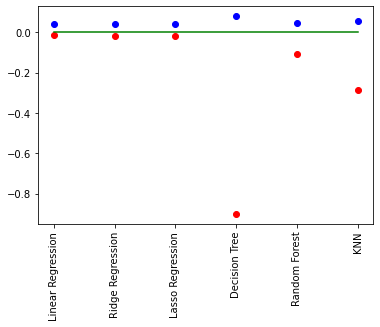

In [278]:
plt.scatter(names, mse_metric, color='b')
plt.plot(names, np.zeros(len(names)), color='g')
plt.scatter(names, r2, color='r')
plt.xticks(rotation=90)
plt.show()

We can see, that the best results are given by Linear Regression, Ridge Regression, Lasso Regression. 
Decision Tree showed the worst result. 

Even though the MSE metric seems to be low, the r2-score shows that all the models perform quite poorly. 

Let's check which metrics had the highest and lowest impact. 

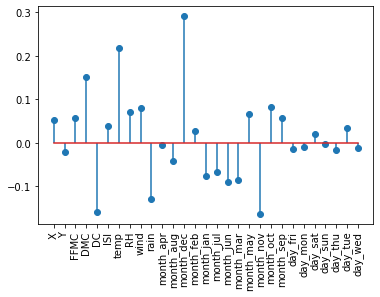

In [235]:
plt.stem(X.columns, models[0].coef_)
plt.xticks(rotation=90)
plt.show()

From here we can see, that the highest impact has month_dec, month_nov, temp, and DC. 

The lowest impact (around zero) show month_apr and day_sun. 

Let's exclude it to get the impression whether it's gonna improve our model. 

In [271]:
X2_train = X_train.drop(['month_apr', 'day_sun'], axis=1)
X2_test = X_test.drop(['month_apr', 'day_sun'], axis=1)
models2 = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor()]

mse_metric2=[]
r2_2=[]
for i in range(len(names)):
    models2[i].fit(X2_train, y_train)
    y2_pred = models2[i].predict(X2_test)
    mse_metric2.append(mse(y_test, y2_pred))
    r2_2.append(r2_score(y_test, y2_pred))
    print(str(names[i]) + '\t mse: ' + str(mse(y_test, y2_pred))
         + '\t' + 'r2_score: ' + str(r2_score(y_test, y2_pred)))

Linear Regression	 mse: 0.04460199976178266	r2_score: -0.07509518718305741
Ridge Regression	 mse: 0.04442841031840777	r2_score: -0.07091095382771706
Lasso Regression	 mse: 0.042197511753643266	r2_score: -0.01713694542267219
Decision Tree	 mse: 0.08669924315604798	r2_score: -1.0898152447717822
Random Forest	 mse: 0.0556818153950645	r2_score: -0.34216519583373706
KNN	 mse: 0.046157002	r2_score: -0.11257729570404984


In [522]:
X2_train = X_train.drop('month_dec', axis=1)
X2_test = X_test.drop('month_dec', axis=1)
models3 = [LinearRegression(), Ridge(), Lasso(), DecisionTreeRegressor(), RandomForestRegressor(), KNeighborsRegressor()]

mse_metric3=[]
r2_3=[]
for i in range(len(names)):
    models3[i].fit(X2_train2, y_train)
    y2_pred3 = models3[i].predict(X2_test2)
    mse_metric3.append(mse(y_test, y2_pred3))
    r2_3.append(r2_score(y_test, y2_pred2))
    print(str(names[i]) + '\t mse: ' + str(mse(y_test, y2_pred3))
         + '\t' + 'r2_score: ' + str(r2_score(y_test, y2_pred3)))

Linear Regression	 mse: 0.042070244	r2_score: -0.014069223749523907
Ridge Regression	 mse: 0.04283706	r2_score: -0.032552783994123535
Lasso Regression	 mse: 0.04219751	r2_score: -0.01713700763196524
Decision Tree	 mse: 0.08095929025871867	r2_score: -0.951458315317157
Random Forest	 mse: 0.04692309713302257	r2_score: -0.13104336498071456
KNN	 mse: 0.05357171	r2_score: -0.2913027583297516


Removing month_dec resulted in increasing the weights of the other months. 

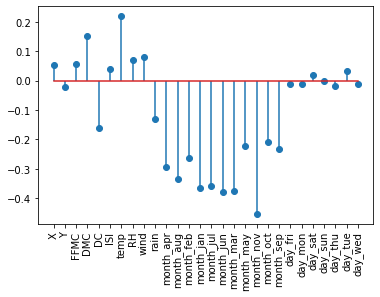

In [514]:
plt.stem(X.columns.drop('month_dec'), models3[0].coef_)
plt.xticks(rotation=90)
plt.show()

/tmp/ipykernel_20518/2560829346.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax0.set_xticklabels(names, rotation=45)
/tmp/ipykernel_20518/2560829346.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(names, rotation=45)


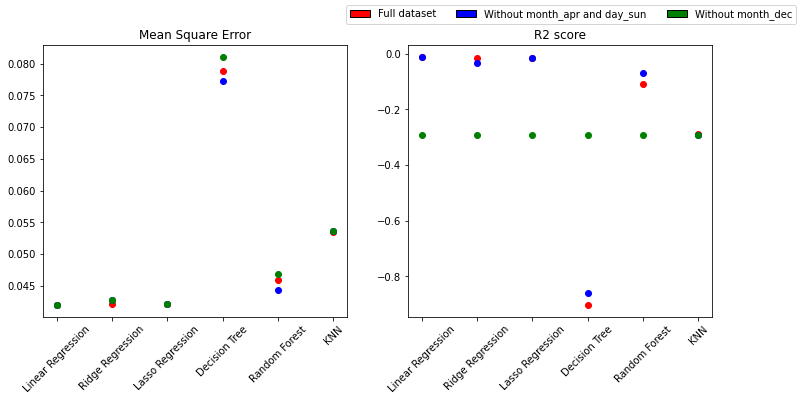

In [560]:
from matplotlib.patches import Rectangle

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(5)
fig.set_figwidth(12)
labels=['Full dataset', 'Without month_apr and day_sun', 'Without month_dec']
colors = ["red", "blue", "green"]
handles = [Rectangle((0, 0), 1, 1, color=c, ec="k") for c in colors]
ax0.scatter(names, mse_metric, color='r')
ax0.scatter(names, mse_metric2, color='b')
ax0.scatter(names, mse_metric3, color='g')
ax0.set_xticklabels(names, rotation=45)
ax0.set_title('Mean Square Error')
ax1.scatter(names, r2, color='r')
ax1.scatter(names, r2_2, color='b')
ax1.scatter(names, r2_3, color='g')
ax1.set_xticklabels(names, rotation=45)
ax1.set_title('R2 score')
fig.legend(handles, labels, ncol=3)
plt.show()

## NN

Let's try if a simple NN can perform better. 

In [22]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')

In [23]:
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [604]:
input_size=29
output_size=1
NN = Sequential()
NN.add(Dense(29, input_dim = X_train.shape[1], activation = 'relu')) 
NN.add(Dense(29, activation = 'sigmoid'))
NN.add(Dense(1, activation = 'relu'))
NN.compile(loss="mean_squared_error",metrics=['mse'])
NN.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_184 (Dense)           (None, 29)                870       
                                                                 
 dense_185 (Dense)           (None, 29)                870       
                                                                 
 dense_186 (Dense)           (None, 1)                 30        
                                                                 
Total params: 1,770
Trainable params: 1,770
Non-trainable params: 0
_________________________________________________________________


In [605]:
history1 = NN.fit(X_train,y_train,epochs=100, validation_split=0.2)

Epoch 1/100
11/11 [==============================] - 0s 12ms/step - loss: 1.6537 - mse: 1.6537 - val_loss: 0.9184 - val_mse: 0.9184
Epoch 2/100
11/11 [==============================] - 0s 4ms/step - loss: 0.7475 - mse: 0.7475 - val_loss: 0.4010 - val_mse: 0.4010
Epoch 3/100
11/11 [==============================] - 0s 4ms/step - loss: 0.3181 - mse: 0.3181 - val_loss: 0.1578 - val_mse: 0.1578
Epoch 4/100
11/11 [==============================] - 0s 4ms/step - loss: 0.1265 - mse: 0.1265 - val_loss: 0.0878 - val_mse: 0.0878
Epoch 5/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0792 - val_mse: 0.0792
Epoch 6/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0598 - mse: 0.0598 - val_loss: 0.0774 - val_mse: 0.0774
Epoch 7/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0562 - mse: 0.0562 - val_loss: 0.0748 - val_mse: 0.0748
Epoch 8/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0535 - 

11/11 [==============================] - 0s 4ms/step - loss: 0.0286 - mse: 0.0286 - val_loss: 0.0551 - val_mse: 0.0551
Epoch 64/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0282 - mse: 0.0282 - val_loss: 0.0517 - val_mse: 0.0517
Epoch 65/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0628 - val_mse: 0.0628
Epoch 66/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0536 - val_mse: 0.0536
Epoch 67/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0280 - mse: 0.0280 - val_loss: 0.0566 - val_mse: 0.0566
Epoch 68/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0275 - mse: 0.0275 - val_loss: 0.0536 - val_mse: 0.0536
Epoch 69/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0278 - mse: 0.0278 - val_loss: 0.0511 - val_mse: 0.0511
Epoch 70/100
11/11 [==============================] - 0s 4ms/step - loss: 0.0278 - mse: 0

In [606]:
y_preds = NN.predict(X_test)

4/4 [==============================] - 0s 1ms/step


In [607]:
print('NN mse: ' + str(mse(y_test, y_preds))
         + '\t' + 'r2_score: ' + str(r2_score(y_test, y_preds)))

NN mse: 0.052216657	r2_score: -0.2586404207893569


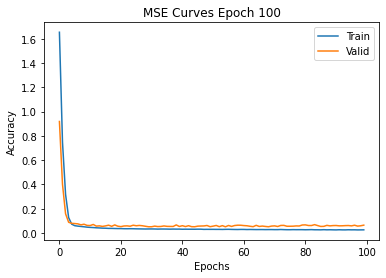

In [626]:
plt.plot(history1.history['mse'], label='Train')
plt.plot(history1.history['val_mse'], label='Valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MSE Curves Epoch 100')
plt.show()

## Let's switch to classification problem

Since regression shows such a poor result, let's switch to classification problem. 

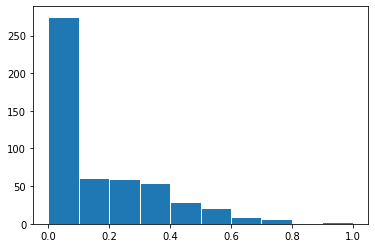

In [67]:
plt.hist(data['area'], bins=10, edgecolor='white', linewidth=1)
plt.show()

Let's make new columns for normilized data:
- area < 0.1
- 0.1 <= area < 0.2
- 0.2 <= area < 0.3
- 0.3 <= area < 0.4
- 0.4 <= area < 0.5
- 0.5 <= area < 0.6
- 0.6 <= area < 0.7
- 0.7 <= area < 0.8
- 0.8 <= area < 0.9
- 0.9 <= area < 1.0

In [87]:
y = pd.DataFrame(data['area'])
y['< 0.1'] = (y['area']<0.1).astype(int)
y['[0.1, 0.2)'] = ((y['area']>=0.1) & (y['area']<0.2)).astype(int)
y['[0.2, 0.3)'] = ((y['area']>=0.2) & (y['area']<0.3)).astype(int)
y['[0.3, 0.4)'] = ((y['area']>=0.3) & (y['area']<0.4)).astype(int)
y['[0.4, 0.5)'] = ((y['area']>=0.4) & (y['area']<0.5)).astype(int)
y['[0.5, 0.6)'] = ((y['area']>=0.5) & (y['area']<0.6)).astype(int)
y['[0.6, 0.7)'] = ((y['area']>=0.6) & (y['area']<0.7)).astype(int)
y['[0.7, 0.8)'] = ((y['area']>=0.7) & (y['area']<0.8)).astype(int)
y['[0.8, 0.9)'] = ((y['area']>=0.8) & (y['area']<0.9)).astype(int)
y['>= 0.9'] = ((y['area']>=0.9)).astype(int)
y = y.drop('area', axis=1)

In [88]:
y

,< 0.1,"[0.1, 0.2)","[0.2, 0.3)","[0.3, 0.4)","[0.4, 0.5)","[0.5, 0.6)","[0.6, 0.7)","[0.7, 0.8)","[0.8, 0.9)",>= 0.9
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
512,0,0,1,0,0,0,0,0,0,0
513,0,0,0,0,0,1,0,0,0,0
514,0,0,0,1,0,0,0,0,0,0
515,1,0,0,0,0,0,0,0,0,0


In [93]:
X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X, y, test_size = 0.2)

In [627]:
names_cl = ['Decision Tree', 'Random Forest']
models_cl = [DecisionTreeClassifier(max_depth=1), RandomForestClassifier(n_estimators=50, max_depth=1)]

acc=[]
for i in range(len(names_cl)):
    models_cl[i].fit(X_train_cl, y_train_cl)
    y_pred_cl = models_cl[i].predict(X_test_cl)
    acc.append(accuracy_score(y_test_cl, y_pred_cl))
    print(str(names_cl[i]) + ' accuracy: ' + str(accuracy_score(y_test_cl, y_pred_cl)))

Decision Tree accuracy: 0.5096153846153846
Random Forest accuracy: 0.5


In [343]:
for i in range(1,100,5):
    rcl = RandomForestClassifier(max_depth=i)
    rcl.fit(X_train_cl, y_train_cl)
    y_pred_cl = rcl.predict(X_test_cl)
    print('accuracy score for max depth ' + str(i) +' is ' + str(accuracy_score(y_test_cl, y_pred_cl)))

accuracy score for max depth 1 is 0.5
accuracy score for max depth 6 is 0.3942307692307692
accuracy score for max depth 11 is 0.3076923076923077
accuracy score for max depth 16 is 0.3173076923076923
accuracy score for max depth 21 is 0.3173076923076923
accuracy score for max depth 26 is 0.2980769230769231
accuracy score for max depth 31 is 0.2980769230769231
accuracy score for max depth 36 is 0.28846153846153844
accuracy score for max depth 41 is 0.3173076923076923
accuracy score for max depth 46 is 0.3076923076923077
accuracy score for max depth 51 is 0.2980769230769231
accuracy score for max depth 56 is 0.27884615384615385
accuracy score for max depth 61 is 0.2980769230769231
accuracy score for max depth 66 is 0.3173076923076923
accuracy score for max depth 71 is 0.2980769230769231
accuracy score for max depth 76 is 0.2980769230769231
accuracy score for max depth 81 is 0.2980769230769231
accuracy score for max depth 86 is 0.27884615384615385
accuracy score for max depth 91 is 0.29807

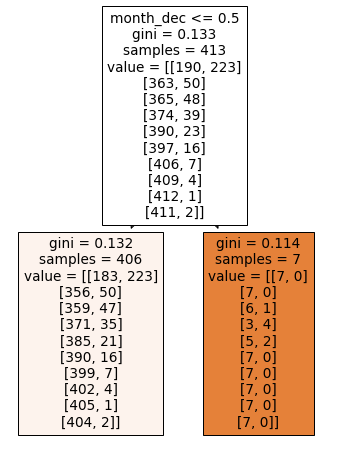

In [344]:
fig = plt.figure(figsize=(6,8))
_ = tree.plot_tree(models_cl[0], 
                   feature_names=X.columns,  
                   class_names=y.columns,
                   filled=True)

In [346]:
data[data['month_dec'] == 0][data['area'] == 0].shape

/tmp/ipykernel_20518/2774335629.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['month_dec'] == 0][data['area'] == 0].shape


(247, 30)

In [333]:
data[data['area'] == 0].shape

(247, 30)

In [336]:
data[data['month_dec'] == 0].shape

(508, 30)

## NN for classification

In [663]:
input_size=29
output_size=10
NN_cl = Sequential()
NN_cl.add(Dense(20, input_dim = X_train_cl.shape[1], activation = 'sigmoid')) 
NN_cl.add(Dense(10, activation = 'softmax'))
NN_cl.compile(optimizer='adam', loss="categorical_crossentropy",metrics=['accuracy'])
NN_cl.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_232 (Dense)           (None, 20)                600       
                                                                 
 dense_233 (Dense)           (None, 10)                210       
                                                                 
Total params: 810
Trainable params: 810
Non-trainable params: 0
_________________________________________________________________


In [664]:
history2 = NN_cl.fit(X_train_cl, y_train_cl, validation_split=0.2, epochs=20)

Epoch 1/20
11/11 [==============================] - 0s 15ms/step - loss: 2.1081 - accuracy: 0.0848 - val_loss: 1.9953 - val_accuracy: 0.1325
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 1.9855 - accuracy: 0.0848 - val_loss: 1.8847 - val_accuracy: 0.1446
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 1.8809 - accuracy: 0.2606 - val_loss: 1.7932 - val_accuracy: 0.4578
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 1.7956 - accuracy: 0.5212 - val_loss: 1.7200 - val_accuracy: 0.5301
Epoch 5/20
11/11 [==============================] - 0s 5ms/step - loss: 1.7266 - accuracy: 0.5424 - val_loss: 1.6642 - val_accuracy: 0.5301
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 1.6711 - accuracy: 0.5424 - val_loss: 1.6225 - val_accuracy: 0.5301
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 1.6307 - accuracy: 0.5424 - val_loss: 1.5907 - val_accuracy: 0.5301
Epoch 8/20
11/11 [=

In [672]:
y_pred_cl = NN_cl.predict(X_test_cl)

4/4 [==============================] - 0s 1ms/step


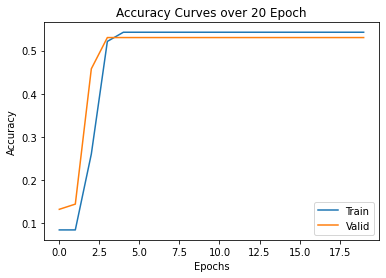

In [673]:
plt.plot(history2.history['accuracy'], label='Train')
plt.plot(history2.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves over 20 Epoch')
plt.show()

In [674]:
cm = confusion_matrix(np.asarray(y_test_cl).argmax(axis=1), np.asarray(y_pred_cl).argmax(axis=1))

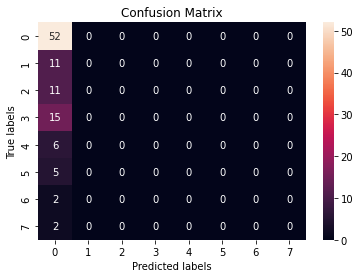

In [675]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 